In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cdist

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
#folder_path = ""
folder_path = 'drive/MyDrive/pose_detection/'

In [3]:
df = pd.read_csv(folder_path + 'var_3.csv', index_col='ID').drop(columns=['Unnamed: 0'])
df.head()

NAME  r ankle_X  r ankle_Y  r knee_X  r knee_Y  r hip_X  \
ID                                                                       
1579  068840502.jpg        301        436       298       358      297   
1580  037455289.jpg        407        292       401       248      398   
1581  016686020.jpg         -1         -1        -1        -1      285   
1582  043052934.jpg        298        234       295       187      298   
1583  014259414.jpg         -1         -1      1196       617     1212   

      r hip_Y  l hip_X  l hip_Y  l knee_X  ...  r shoulder_Y  l shoulder_X  \
ID                                         ...                               
1579      298      324      293       328  ...           211           334   
1580      197      414      194       414  ...           139           413   
1581      465      339      462        -1  ...           305           321   
1582      148      321      151       325  ...           110           354   
1583      487     1147      485      1101  ...           360          1143   

      l shoulder_Y  l elbow_X  l elbow_Y  l wrist_X  l wrist_Y     Scale  \
ID                                                                         
1579           216        319        256        285        242  1.968146   
1580           140        403        177        374        165  1.463016   
1581           291        337        313        334        224  4.194579   
1582           113        350        142        354        171  0.952773   
1583           355       1095        429       1074        492  2.801428   

                                               Activity  Category  
ID                                                                 
1579  children_s games, adults playing (e.g., hopsco...    sports  
1580  children_s games, adults playing (e.g., hopsco...    sports  
1581  children_s games, adults playing (e.g., hopsco...    sports  
1582  children_s games, adults playing (e.g., hopsco...    sports  
1583  children_s games, adults playing (e.g., hopsco...    sports  

[5 rows x 36 columns]

In [4]:
activities_count = df['Activity'].unique().shape[0]
categories_count = df['Category'].unique().shape[0]
keypoints_count = sum(col.endswith('X') or col.endswith('Y') for col in df.columns)
activities_count, categories_count, keypoints_count

(56, 16, 32)

In [5]:
label_encoder_activity = LabelEncoder()
labels_activity = df['Activity'].values
label_encoder_activity.fit(labels_activity)
df['Activity'] = label_encoder_activity.transform(df['Activity'])

label_encoder_category = LabelEncoder()
labels_category = df['Category'].values
label_encoder_category.fit(labels_category)
df['Category'] = label_encoder_category.transform(df['Category'])

In [6]:
activity_label_map = {index: label for index, label in enumerate(label_encoder_activity.classes_)}
category_label_map = {index: label for index, label in enumerate(label_encoder_category.classes_)}

In [7]:
imputed_df = df.copy()

keypoints_columns = imputed_df.columns[1:-3]

for index, row in imputed_df.iterrows():
    keypoints = row[keypoints_columns].astype(float).values
    for i in range(len(keypoints)):
        if keypoints[i] == -1:
            distances = cdist(keypoints.reshape(-1, 1), keypoints.reshape(-1, 1))
            closest_index = np.argmin(distances[np.where(keypoints != -1)])
            imputed_df.at[index, keypoints_columns[i]] = keypoints[closest_index]

In [8]:
imputed_df.head()

NAME  r ankle_X  r ankle_Y  r knee_X  r knee_Y  r hip_X  \
ID                                                                       
1579  068840502.jpg        301        436       298       358      297   
1580  037455289.jpg        407        292       401       248      398   
1581  016686020.jpg        285        285       285       285      285   
1582  043052934.jpg        298        234       295       187      298   
1583  014259414.jpg       1196       1196      1196       617     1212   

      r hip_Y  l hip_X  l hip_Y  l knee_X  ...  r shoulder_Y  l shoulder_X  \
ID                                         ...                               
1579      298      324      293       328  ...           211           334   
1580      197      414      194       414  ...           139           413   
1581      465      339      462       285  ...           305           321   
1582      148      321      151       325  ...           110           354   
1583      487     1147      485      1101  ...           360          1143   

      l shoulder_Y  l elbow_X  l elbow_Y  l wrist_X  l wrist_Y     Scale  \
ID                                                                         
1579           216        319        256        285        242  1.968146   
1580           140        403        177        374        165  1.463016   
1581           291        337        313        334        224  4.194579   
1582           113        350        142        354        171  0.952773   
1583           355       1095        429       1074        492  2.801428   

      Activity  Category  
ID                        
1579         8        11  
1580         8        11  
1581         8        11  
1582         8        11  
1583         8        11  

[5 rows x 36 columns]

In [9]:
def draw(points, image, activity, category):
    fig, ax = plt.subplots()

    ax.text(0, -10, f'Activity: {activity_label_map[activity]}', color='black', fontsize=10)
    ax.text(0, -70, f'Category: {category_label_map[category]}', color='black', fontsize=10)

    ax.imshow(image)

    keypoints_x = points[::2]
    keypoints_y = points[1::2]

    bones = [(0, 1), (1, 2), (2, 3), (3, 4), (2, 5), (5, 6), (6, 7), (7, 8),
             (2, 9), (9, 10), (10, 11), (11, 12), (2, 13), (13, 14), (14, 15), (15, 16)]

    for i in range(len(keypoints_x)):
        ax.scatter(keypoints_x[i], keypoints_y[i], color='red', marker='o')
        ax.text(keypoints_x[i], keypoints_y[i], str(i), color='white', fontsize=8, ha='center', va='center')

    for bone in bones:
        if bone[0] < len(keypoints_x) and bone[1] < len(keypoints_x):
            x_values = [keypoints_x[bone[0]], keypoints_x[bone[1]]]
            y_values = [keypoints_y[bone[0]], keypoints_y[bone[1]]]
            ax.plot(x_values, y_values, color='blue')

    ax.axis('off')

    plt.show()

In [10]:
class KeypointActivityDataset(Dataset):
    def __init__(self, csv_file, root_dir, size, transform=None):
        self.keypoints_frame = csv_file.copy()
        self.root_dir = root_dir
        self.transform = transform
        self.size = size

    def __len__(self):
        return len(self.keypoints_frame)

    def __getitem__(self, idx):

        img_name = self.keypoints_frame.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        scale_x = self.size / image.width
        scale_y = self.size / image.height

        keypoints = self.keypoints_frame.iloc[idx, 1:-3].values.astype('float').copy()
        for i in range(keypoints.shape[0]):
            if keypoints[i] != -1:
                if i % 2 == 0:
                    keypoints[i] *= scale_x
                else:
                    keypoints[i] *= scale_y
        keypoints = torch.tensor(keypoints, dtype=torch.float32)

        activity_category = self.keypoints_frame.iloc[idx, -2:].copy()
        activity = torch.tensor(activity_category['Activity'], dtype=torch.long)
        category = torch.tensor(activity_category['Category'], dtype=torch.long)

        sample = {'image': image, 'keypoints': keypoints, 'activity': activity, 'category': category, 'scale_x': scale_x, 'scale_y': scale_y, 'img_path': img_path}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample

In [137]:
size = 128
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
batch_size = 4

data = imputed_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_data, temp_data = train_test_split(data, test_size=(1 - train_ratio), random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)

train_dataset = KeypointActivityDataset(train_data, folder_path + 'images/', size, transform=transform)
val_dataset = KeypointActivityDataset(val_data, folder_path + 'images/', size, transform=transform)
test_dataset = KeypointActivityDataset(test_data, folder_path + 'images/', size, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
def train(model, train_loader, val_loader, optimizer, criterion_keypoints, criterion_activities, criterion_categories, num_epochs):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in tqdm(train_loader):
            inputs, keypoints, activities, categories = data['image'].to(device), data['keypoints'].to(device), data['activity'].to(device), data['category'].to(device)

            optimizer.zero_grad()

            keypoints_pred, activities_pred, categories_pred = model(inputs)
            loss_keypoints = criterion_keypoints(keypoints_pred, keypoints)
            loss_activities = criterion_activities(activities_pred, activities)
            loss_categories = criterion_categories(categories_pred, categories)

            loss = loss_keypoints + loss_activities + loss_categories

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_epoch_loss = running_loss/len(train_loader)
        train_losses.append(train_epoch_loss)
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for data in tqdm(val_loader):
                inputs, keypoints, activities, categories = data['image'].to(device), data['keypoints'].to(device), data['activity'].to(device), data['category'].to(device)

                keypoints_pred, activities_pred, categories_pred = model(inputs)

                loss_keypoints = criterion_keypoints(keypoints_pred, keypoints)
                loss_activities = criterion_activities(activities_pred, activities)
                loss_categories = criterion_categories(categories_pred, categories)

                loss = loss_keypoints + loss_activities + loss_categories

                val_loss += loss.item()

            val_epoch_loss = val_loss/len(val_loader)
            val_losses.append(val_epoch_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {train_epoch_loss:.4f}, Val loss: {val_epoch_loss:.4f}")

    return model, train_losses, val_losses

In [13]:
def predict(model, loader):

    all_predictions = {'pred_keypoints': [], 'pred_activities': [], 'pred_categories': [], 'true_keypoints': [], 'true_activities': [], 'true_categories': [], 'inputs': []}

    model.eval()
    with torch.no_grad():
        for data in tqdm(loader):
            inputs, keypoints, activities, categories, scale_x, scale_y, img_path = data['image'].to(device), data['keypoints'], data['activity'], data['category'], data['scale_x'], data['scale_y'], data['img_path']

            keypoints_pred, activities_pred, categories_pred = model(inputs)
            keypoints_pred = keypoints_pred.detach().cpu().numpy().copy()
            for i in range(keypoints_pred.shape[0]):
                for j in range(keypoints_pred.shape[1]):
                    if keypoints_pred[i][j] != -1:
                        if j % 2 == 0:
                            keypoints_pred[i][j] /= scale_x[i]
                        else:
                            keypoints_pred[i][j] /= scale_y[i]
            for i in range(keypoints.shape[0]):
                for j in range(keypoints.shape[1]):
                    if keypoints[i][j] != -1:
                        if j % 2 == 0:
                            keypoints[i][j] /= scale_x[i]
                        else:
                            keypoints[i][j] /= scale_y[i]

            all_predictions['pred_keypoints'].append(keypoints_pred)
            all_predictions['pred_activities'].append(activities_pred.argmax(dim=1).cpu().numpy())
            all_predictions['pred_categories'].append(categories_pred.argmax(dim=1).cpu().numpy())
            all_predictions['true_keypoints'].append(keypoints.numpy())
            all_predictions['true_activities'].append(activities.numpy())
            all_predictions['true_categories'].append(categories.numpy())
            all_predictions['inputs'].append(img_path)

    for key in all_predictions.keys():
        all_predictions[key] = np.concatenate(all_predictions[key])

    return all_predictions

In [14]:
def calculate_metrics(keypoints_true, keypoints_pred, activities_true, activities_pred, categories_true, categories_pred, loader_type):
    mse_keypoints = mean_squared_error(keypoints_true, keypoints_pred)
    rmse_keypoints = np.sqrt(mse_keypoints)
    mae_keypoints = np.mean(np.abs(keypoints_true - keypoints_pred))

    accuracy_activities = accuracy_score(activities_true, activities_pred)
    precision_activities = precision_score(activities_true, activities_pred, average='weighted', zero_division=0)
    recall_activities = recall_score(activities_true, activities_pred, average='weighted', zero_division=0)
    f1_activities = f1_score(activities_true, activities_pred, average='weighted')

    accuracy_categories = accuracy_score(categories_true, categories_pred)
    precision_categories = precision_score(categories_true, categories_pred, average='weighted', zero_division=0)
    recall_categories = recall_score(categories_true, categories_pred, average='weighted', zero_division=0)
    f1_categories = f1_score(categories_true, categories_pred, average='weighted')

    mtl_score = (accuracy_activities + accuracy_categories) / 2

    print(f"Metrics for {loader_type}:\nKeypoint MSE: {mse_keypoints},\nKeypoint RMSE: {rmse_keypoints},\nKeypoint MAE: {mae_keypoints},\nActivity Accuracy: {accuracy_activities},\nActivity Precision: {precision_activities},\nActivity Recall: {recall_activities},\nActivity F1-score: {f1_activities},\nCategory Accuracy: {accuracy_categories},\nCategory Precision: {precision_categories},\nCategory Recall: {recall_categories},\nCategory F1-score: {f1_categories},\nMTL Score: {mtl_score}")

In [15]:
def validate(model, loader, images_to_draw, loader_type):
    predictions = predict(model, loader)

    calculate_metrics(predictions['true_keypoints'], predictions['pred_keypoints'], predictions['true_activities'],
                      predictions['pred_activities'], predictions['true_categories'], predictions['pred_categories'], loader_type)

    for i in range(images_to_draw):
        file_path = predictions['inputs'][i]
        image = Image.open(file_path)
        draw(predictions['pred_keypoints'][i], image, predictions['pred_activities'][i], predictions['pred_categories'][i])

In [138]:
class KeypointActivityModel(nn.Module):
    def __init__(self, num_keypoints, num_activities, num_categories):
        super(KeypointActivityModel, self).__init__()

        self.backbone = models.resnet50(weights='IMAGENET1K_V2')

        for param in self.backbone.parameters():
            param.requires_grad = False

        self.keypoint_fc = nn.Linear(1000, num_keypoints)

        self.activity_fc = nn.Linear(1000, num_activities)

        self.category_fc = nn.Linear(1000, num_categories)

    def forward(self, x):
        features = self.backbone(x)

        keypoints = self.keypoint_fc(features)
        activities = self.activity_fc(features)
        categories = self.category_fc(features)

        return keypoints, activities, categories

In [139]:
model = KeypointActivityModel(keypoints_count, activities_count, categories_count).to(device)

In [140]:
learning_rate = 0.001
num_epochs = 30
criterion_keypoints = nn.MSELoss()
criterion_activities = nn.CrossEntropyLoss()
criterion_categories = nn.CrossEntropyLoss()

optimizer = optim.Adamax(model.parameters(), lr=learning_rate)

In [141]:
model, train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion_keypoints, criterion_activities, criterion_categories, num_epochs)

100%|██████████| 30/30 [00:05<00:00,  5.87it/s]


Epoch [1/30], Train loss: 4775.9353, Val loss: 4665.4662


100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Epoch [2/30], Train loss: 4383.6675, Val loss: 4361.9921


100%|██████████| 30/30 [00:02<00:00, 11.99it/s]


Epoch [3/30], Train loss: 4070.7604, Val loss: 4474.6913


100%|██████████| 30/30 [00:02<00:00, 12.45it/s]


Epoch [4/30], Train loss: 3827.3603, Val loss: 4231.7245


100%|██████████| 30/30 [00:02<00:00, 12.25it/s]


Epoch [5/30], Train loss: 3639.3073, Val loss: 3973.0392


100%|██████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch [6/30], Train loss: 3445.8130, Val loss: 4141.2554


100%|██████████| 30/30 [00:03<00:00,  9.98it/s]


Epoch [7/30], Train loss: 3215.3774, Val loss: 3726.4060


100%|██████████| 30/30 [00:03<00:00,  7.73it/s]


Epoch [8/30], Train loss: 3070.8564, Val loss: 3995.5364


100%|██████████| 30/30 [00:03<00:00,  9.26it/s]


Epoch [9/30], Train loss: 2943.9599, Val loss: 3397.6197


100%|██████████| 30/30 [00:02<00:00, 11.86it/s]


Epoch [10/30], Train loss: 2783.7465, Val loss: 3594.1362


100%|██████████| 30/30 [00:02<00:00, 12.01it/s]


Epoch [11/30], Train loss: 2746.4626, Val loss: 3543.1267


100%|██████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch [12/30], Train loss: 2627.3495, Val loss: 3377.0428


100%|██████████| 30/30 [00:02<00:00, 12.15it/s]


Epoch [13/30], Train loss: 2536.9038, Val loss: 3619.5860


100%|██████████| 30/30 [00:02<00:00, 10.78it/s]


Epoch [14/30], Train loss: 2480.0126, Val loss: 3419.8733


100%|██████████| 30/30 [00:05<00:00,  5.48it/s]


Epoch [15/30], Train loss: 2382.2550, Val loss: 3043.6354


100%|██████████| 30/30 [00:03<00:00,  9.59it/s]


Epoch [16/30], Train loss: 2275.4166, Val loss: 3174.7168


100%|██████████| 30/30 [00:02<00:00, 12.24it/s]


Epoch [17/30], Train loss: 2288.6378, Val loss: 3350.3731


100%|██████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch [18/30], Train loss: 2188.0227, Val loss: 3577.0376


100%|██████████| 30/30 [00:02<00:00, 12.03it/s]


Epoch [19/30], Train loss: 2138.0421, Val loss: 2707.3494


100%|██████████| 30/30 [00:02<00:00, 12.21it/s]


Epoch [20/30], Train loss: 2054.0016, Val loss: 3044.1422


100%|██████████| 30/30 [00:02<00:00, 12.23it/s]


Epoch [21/30], Train loss: 2051.3147, Val loss: 3306.7305


100%|██████████| 30/30 [00:02<00:00, 11.51it/s]


Epoch [22/30], Train loss: 2034.6686, Val loss: 2901.8790


100%|██████████| 30/30 [00:03<00:00,  9.09it/s]


Epoch [23/30], Train loss: 2029.1101, Val loss: 2972.8967


100%|██████████| 30/30 [00:03<00:00,  9.35it/s]


Epoch [24/30], Train loss: 1880.3253, Val loss: 3273.7349


100%|██████████| 30/30 [00:02<00:00, 12.21it/s]


Epoch [25/30], Train loss: 1941.9770, Val loss: 3064.1371


100%|██████████| 30/30 [00:02<00:00, 12.30it/s]


Epoch [26/30], Train loss: 1898.9271, Val loss: 2619.1616


100%|██████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch [27/30], Train loss: 1865.4970, Val loss: 2817.4140


100%|██████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch [28/30], Train loss: 1783.0206, Val loss: 3089.0823


100%|██████████| 30/30 [00:02<00:00, 12.63it/s]


Epoch [29/30], Train loss: 1832.4145, Val loss: 2564.0265


100%|██████████| 30/30 [00:02<00:00, 11.78it/s]

Epoch [30/30], Train loss: 1833.0884, Val loss: 2828.9129


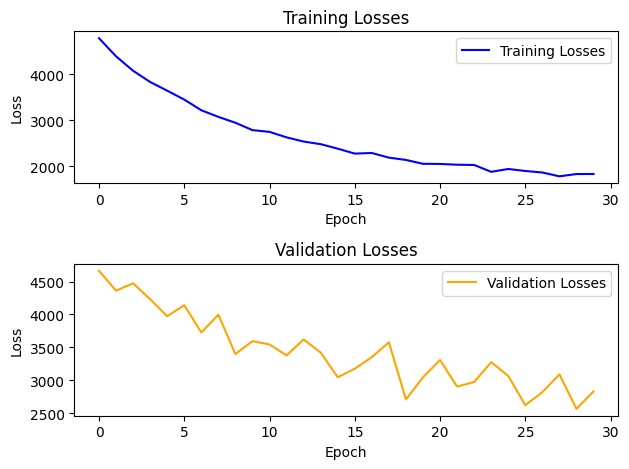

In [142]:
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Losses', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(val_losses, label='Validation Losses', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()

plt.tight_layout()
plt.show()

In [67]:
torch.save(model.state_dict(), "model.pth")

In [145]:
model = KeypointActivityModel(num_keypoints=keypoints_count, num_activities=activities_count, num_categories=categories_count).to(device)
model.load_state_dict(torch.load("model_resnet50.pth"))

<All keys matched successfully>

100%|██████████| 30/30 [00:02<00:00, 11.26it/s]


Metrics for validation:
Keypoint MSE: 43160.44921875,
Keypoint RMSE: 207.7509307861328,
Keypoint MAE: 150.71160888671875,
Activity Accuracy: 0.7796610169491526,
Activity Precision: 0.7585485606672048,
Activity Recall: 0.7796610169491526,
Activity F1-score: 0.7554940014133087,
Category Accuracy: 0.6864406779661016,
Category Precision: 0.7528949492375004,
Category Recall: 0.6864406779661016,
Category F1-score: 0.6988272872216315,
MTL Score: 0.7330508474576272


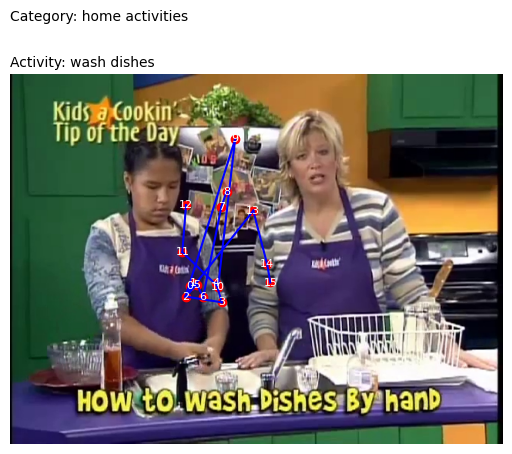

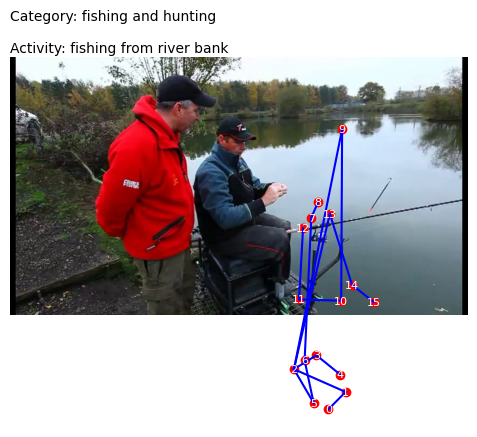

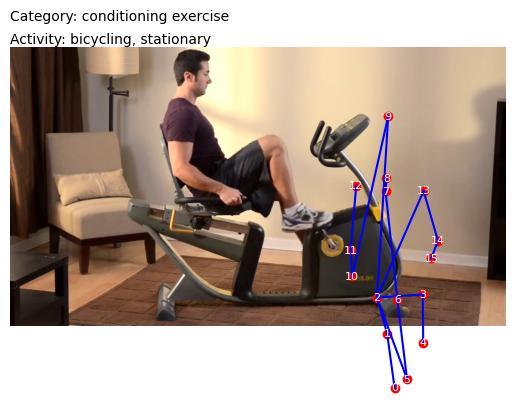

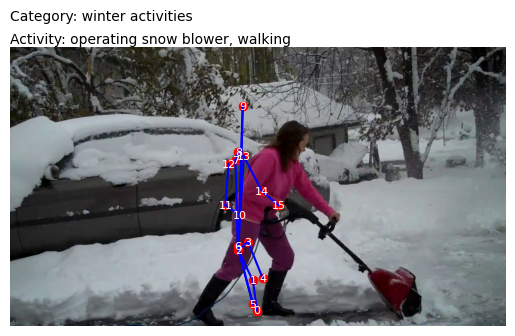

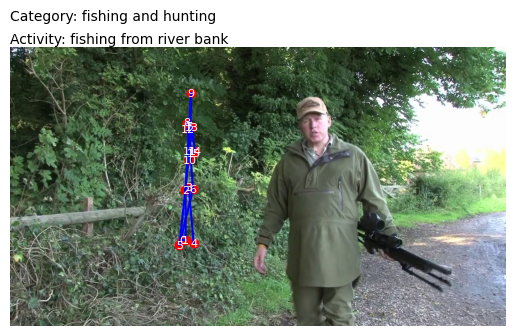

In [149]:
validate(model, val_loader, 5, 'validation')

100%|██████████| 30/30 [00:02<00:00, 11.01it/s]


Metrics for testing:
Keypoint MSE: 51156.01953125,
Keypoint RMSE: 226.17697143554688,
Keypoint MAE: 155.89698791503906,
Activity Accuracy: 0.8067226890756303,
Activity Precision: 0.8043750833666801,
Activity Recall: 0.8067226890756303,
Activity F1-score: 0.793143203141382,
Category Accuracy: 0.7478991596638656,
Category Precision: 0.8002789701154388,
Category Recall: 0.7478991596638656,
Category F1-score: 0.7556994234142512,
MTL Score: 0.7773109243697479


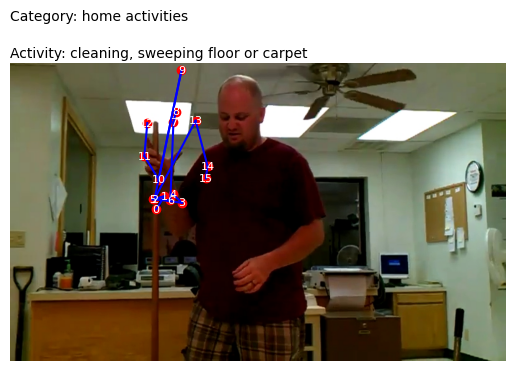

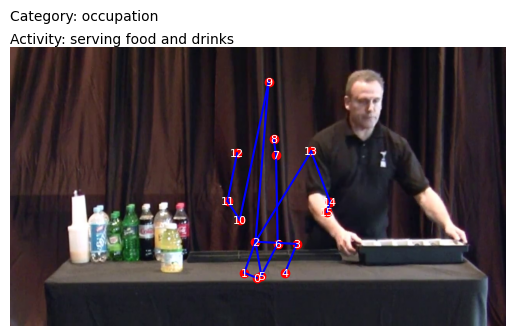

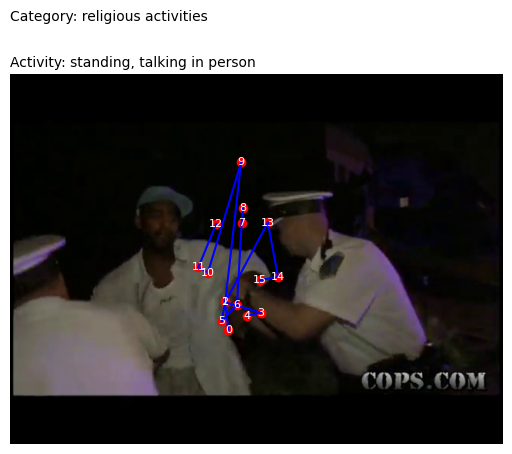

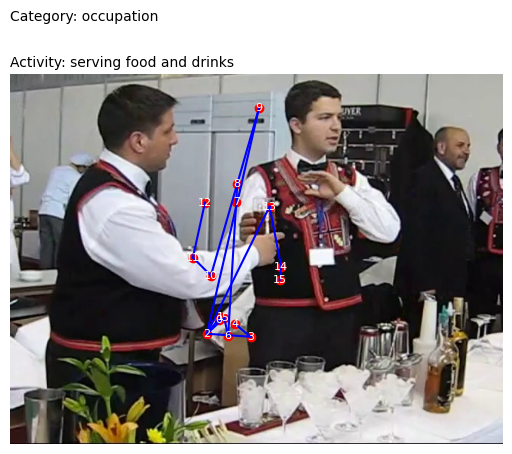

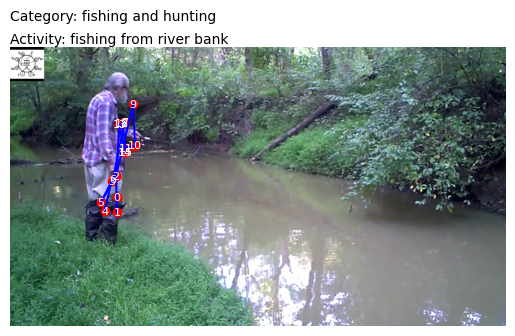

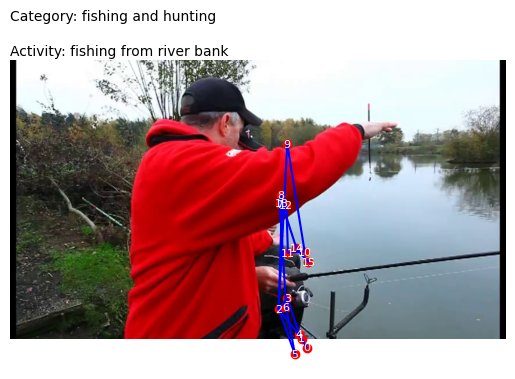

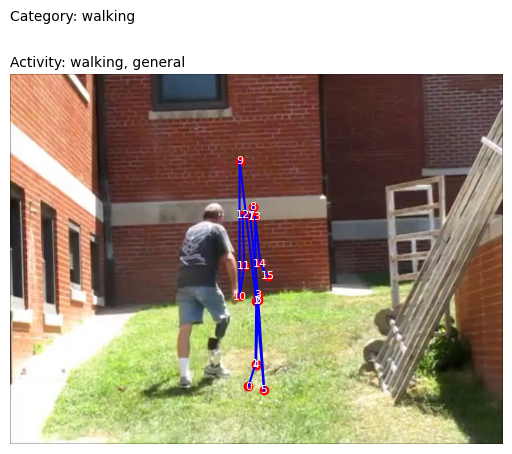

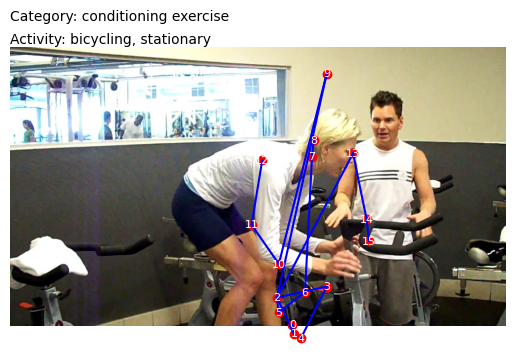

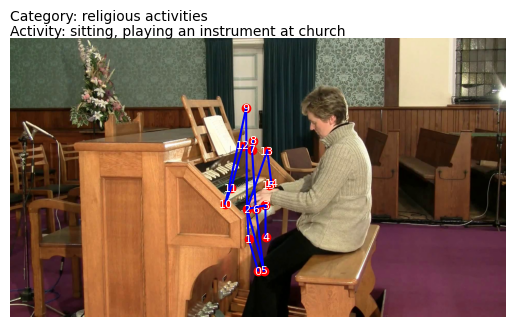

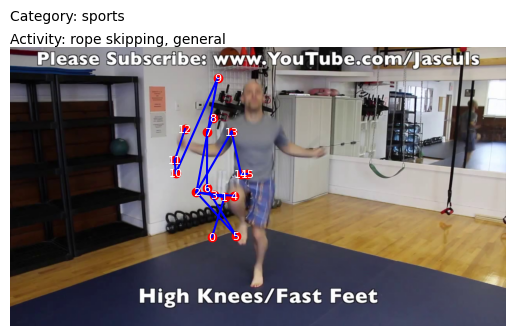

In [150]:
validate(model, test_loader, 10, 'testing')